<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Compensation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
from functools import partial 
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [28]:
#@title Inverse { display-mode: "form" }
def inverse(f):

  def inverse_fn(q):
    
    def closure(p, q):
      return (f(p)-q)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), q)
    return res.params

  return inverse_fn

In [34]:
def output_fn(effort_fn, key, effort):
  return effort_fn(effort) + jax.random.normal(key) 

def parameterized_effort_fn(param):
  return lambda x: param*x

def parameterized_cost_of_effort_fn(param):
  return lambda x: x*param**2  

def parameterized_utility_fn(param):
  return lambda x: x**param 

def parameterized_wage_fn(a, b):
  return lambda x: a + b*x 

In [37]:
def MonetaryValue_and_Output(reservation_wage, output_fn, wage_fn, effort_fn, cost_of_effort_fn, utility_fn, effort):
  omegas = jax.random.split(jax.random.PRNGKey(0))                            # Vector of omegas
  outputs = jax.vmap(partial(output_fn, effort_fn, effort=effort))(omegas)    # Vector of Outputs
  wages = jax.vmap(wage_fn)(outputs)                                          # Vector of Wages 
  utils = jax.vmap(utility_fn)(wages)                                         # Vector of Utils 
  avg_utils = jnp.mean(utils)                                                 # Average Utils (by LLN approx E[U(X)])
  net_utils_from_working = avg_utils - cost_of_effort_fn(effort)                           # expected gain in utils 
  monetary_value_from_working= inverse(utility_fn)(net_utils_from_working)

  return jnp.maximum(monetary_value_from_working, reservation_wage), jnp.where(monetary_value_from_working >= reservation_wage, jnp.mean(outputs), 0.)

reservation_wage = 0.
wage_fn = parameterized_wage_fn(5., 0.)
effort_fn = parameterized_effort_fn(2.)
cost_of_effort_fn = parameterized_cost_of_effort_fn(1.)
utility_fn = parameterized_utility_fn(0.5)


value_fn = partial(MonetaryValue_and_Output, 
                   reservation_wage, 
                   output_fn, 
                   wage_fn,
                   effort_fn, 
                   cost_of_effort_fn, 
                   utility_fn)  

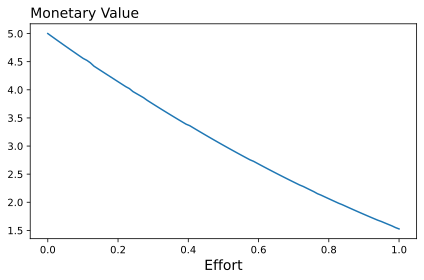

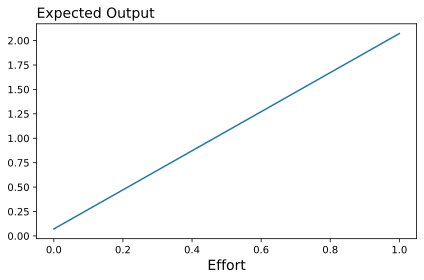

In [39]:
es = jnp.linspace(0,1, 100)
ms, os = jax.vmap(value_fn)(es)
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(es,ms)
plt.title("Monetary Value", loc='left', size=14)
plt.xlabel('Effort', size=14)
fig.savefig('monetary_value.png', format='png')
plt.show()

fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(es,os)
plt.title("Expected Output", loc='left', size=14)
plt.xlabel('Effort', size=14)
fig.savefig('output.png', format='png')
plt.show()

In [24]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

In [40]:
def optimal_effort(wage_params):

  
  def closure(e, wage_params):
    wf = parameterized_wage_fn(*wage_params)
    f = lambda e: -1*MonetaryValue_and_Output(0., output_fn, wf, effort_fn, cost_of_effort_fn, utility_fn, e)[0]
    return f(e)
  solver = ProjectedGradient(fun=closure, projection=projection_non_negative, maxiter=2000)
  res = solver.run(jnp.ones(shape=()), wage_params=wage_params)
  return res.params

optimal_effort((5., 5.))

DeviceArray(1.96535481, dtype=float64)